In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys
import geopandas as gpd
import seaborn as sns
import xarray as xr

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# create a unique ID
grid['grid_idx'] = grid['Fire_ID'].astype(str) + grid['grid_index'].astype(str)

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y
grid = grid.merge(df[['grid_idx','x','y']], on='grid_idx', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_idx']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_idx'], keep='first')


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y'],
      dtype='object')

Dropping [0] duplicate grids.



Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dtype: float64



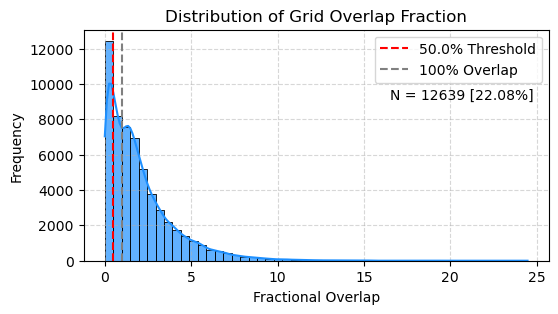

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png


In [3]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.50 # at least 50% overlap
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < thresh]['grid_idx'].count() # less than 5% spatial overlap

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
plt.title('Distribution of Grid Overlap Fraction')
plt.xlabel('Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7, 
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]', 
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

In [4]:
# filter out grids below the overlap threshold
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

Dropping [12639 (22.08%)] grids with <50.0% fractional overlap.
44593


In [5]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the "tm_id" band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = tmid_da.shape, tmid_da.spatial_ref.GeoTransform, tmid_da.rio.crs, tmid_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {tmid_da[0].dtype}")

del treemap_da
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


131

In [6]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(tmid_da), 1, 0)
# calculate the total forested pixels
# see __functions.py 'compute_band_stats'
forest_pct = compute_band_stats(grid, forest_mask, 'grid_idx', attr='constant')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
forest_pct = forest_pct[forest_pct['constant'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_idx','forest_pixels','forest_pct']]

# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"\nSaved multi-band raster to: {out_fp}")

# Join to the grid data
grid = grid.merge(forest_pct, on='grid_idx', how='left')
print(f"\n{grid.columns}")

print("\n~~~~~~~~~~~~~~~\n")
del forest_mask, forest_pct
gc.collect() # clean up


[89.01%] predominantly forest grids.

    grid_idx  forest_pixels  forest_pct
1  161955422            182   91.758242
2  161957669            182  100.000000
3  161957670            196  100.000000

Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Na

16

## TreeMap Tree Table

Summary of the the TreeMap Tree Table information within forested grids identified above. Specifically, we can retrieve an estimate of aspen abundance that goes beyond the algorithmic forest type code assigned to a pixel. In this, we can infer understory/overstory compositions potential to that area.

In [7]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_trees = compute_band_stats(grid, tmid_da, 'grid_idx', attr='tm_id')

# tidy columns in the summary table
grid_trees['count'] = grid_trees['count'].astype(int)
grid_trees['total_pixels'] = grid_trees['total_pixels'].astype(int)
grid_trees.rename(columns={
    'count': 'tmid_count',
    'pct_cover': 'tmid_pct'
}, inplace=True)

# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# join the Tree Table to the grid data
grid_trees = grid_trees.merge(tree_tbl, on='tm_id', how='left')
print(f"\n{grid_trees.head(12)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del tmid_da, tree_tbl # clean up 
gc.collect()

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')

     grid_idx  tm_id  tmid_count  total_pixels  tmid_pct            CN  \
0   161955422   4109           1           167  0.598802  3.727155e+13   
1   161955422   4109           1           167  0.598802  3.727155e+13   
2   161955422   4109           1           167  0.598802  3.727155e+13   
3   161955422   4109           1           167  0.598802  3.727155e+13   
4   161955422   4109           1           167  0.598802  3.727155e+13   
5   161955422   4109           1           167  0.598802  3.727155e+13   
6   161955422   4109           1           167  0.598802  3.727155e+13   
7   161955422   4109           1           167  0.598802  3.727155e+13   
8   161955422   4109           1           167  0.598802  3.727155e+13   
9   161955422   4109           1           167  0.598802 

44

In [8]:
# drop null values of the tree/acre expansion factor
grid_trees = grid_trees.dropna(subset=['TPA_UNADJ'])

In [10]:
# Calculate the Tree Table statistics across tm_id/grid_index combinations
#### Abundance (trees/acre, scaled to per-pixel)
#### Dominance (live basal area, scaled to per-pixel)
#### Tree height (average/species)
#### Tree diameter (average/species)
#### Quadratic mean diameter (QMD)

# force species name to lower case
grid_trees.rename(columns={'COMMON_NAME': 'species'}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
# tidy the live/dead column
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)
# add a tree/pixel based on scaling factor
grid_trees['tpp_unadj'] = grid_trees['TPA_UNADJ'] * 0.222395
# calculate live basal area (balive) scaled by TPA
grid_trees['DIA2'] = grid_trees['DIA'] ** 2 # diameter squared
grid_trees['BA'] = 0.005454 * grid_trees['DIA2']  # Basal area in square feet
grid_trees['BA_TPPsc'] = grid_trees['BA'] * grid_trees['tpp_unadj']  # now adjust based on tree abundance


# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead seperately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_idx', 'tm_id', 'species'], as_index=False)
    .agg(
        # grid-level attributes
        tmid_pixels=('tmid_count','max'), # retains the tm_id pixel count
        tmid_pct=('tmid_pct','max'), # retain the percent of forested area
        # calculate species-level attributes
        tpp_live=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_live=('BA_TPPsc', 'sum'), # total BALIVE
        tree_ht_live=('HT','mean'), # average tree height
        tree_dia_live=('DIA','mean') # average diameter
    )
)

# dead trees
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_idx', 'tm_id', 'species'], as_index=False)
    .agg(
        tpp_dead=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_dead=('BA_TPPsc', 'sum'),    # Live basal area
        tree_ht_dead=('HT','mean'), # average tree height
        tree_dia_dead=('DIA','mean') # average diameter
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics, 
    on=['grid_idx', 'tm_id', 'species'], 
    how='outer'
).fillna(0)

# subset to the tree metric columns
tree_metrics = tree_metrics[[
    'grid_idx','tm_id','tmid_pixels','tmid_pct','species',
    'ba_live','ba_dead', 'tpp_live','tpp_dead', # basal area and trees/pixel
    'tree_ht_live','tree_ht_dead', # tree height
    'tree_dia_live','tree_dia_dead' # tree diameter
]] 

# Add combined (live + dead)
tree_metrics['tpp_ld'] = tree_metrics['tpp_live'] + tree_metrics['tpp_dead']
tree_metrics['ba_ld'] = tree_metrics['ba_live'] + tree_metrics['ba_dead']

# add in forest percent by grid
tree_metrics = tree_metrics.merge(
    grid[['grid_idx','forest_pixels','forest_pct']], 
    on='grid_idx', 
    how='left'
)

# filter out any rows with missing information
tree_metrics = tree_metrics[tree_metrics['tmid_pixels'] > 0]
print(f"\n{tree_metrics.head(12)}\n")
# del live_metrics, dead_metrics, grid_trees
gc.collect()


   grid_idx  tm_id  tmid_pixels   tmid_pct                      species  \
0   0819725   4720          2.0   2.739726  common or two-needle pinyon   
1   0819725   4720          2.0   2.739726              oneseed juniper   
2   0819725   5537          5.0   6.849315           california juniper   
3   0819725   5583          1.0   1.369863  common or two-needle pinyon   
4   0819725   5583          1.0   1.369863                 utah juniper   
5   0819725   5612         12.0  16.438356                 utah juniper   
6   0819725  11444          2.0   2.739726                quaking aspen   
7   0819725  11444          2.0   2.739726      southwestern white pine   
8   0819725  11444          2.0   2.739726                    white fir   
9   0819725  11500          2.0   2.739726                quaking aspen   
10  0819725  11500          2.0   2.739726                    white fir   
11  0819725  11894          3.0   4.109589                quaking aspen   

      ba_live    ba_dea

0

In [12]:
# gather the unique species present
unique_spp = tree_metrics['species'].unique()
unique_spp

array(['common or two-needle pinyon', 'oneseed juniper',
       'california juniper', 'utah juniper', 'quaking aspen',
       'southwestern white pine', 'white fir', 'blue spruce',
       'douglas-fir', 'engelmann spruce', 'lodgepole pine',
       'rocky mountain juniper', 'subalpine fir', 'gambel oak',
       'ponderosa pine', 'corkbark fir', 'limber pine', 'grand fir',
       'arizona pinyon pine', 'singleleaf pinyon', 'black cottonwood',
       'western larch', 'california black oak', 'knobcone pine',
       'sugar pine', 'rocky mountain bristlecone pine', 'red alder',
       'american hornbeam, musclewood', 'blackgum', 'cherrybark oak',
       'loblolly pine', 'southern red oak', 'sweetgum', 'water oak',
       'white oak', 'yellow-poplar', 'curlleaf mountain-mahogany',
       'western white pine', 'jeffrey pine', 'canyon live oak',
       'incense-cedar', 'california red fir', 'western juniper',
       'arizona madrone', 'arizona white oak', 'chihuahuan pine',
       'mexican piny

In [13]:
# make a list of expected forest species
# these are representative of the most common Southern Rockies forest types
srm_spps = [
    'ponderosa pine', 'douglas-fir', 'white fir', # mixed-conifer
    'limber pine', 'blue spruce', 'rocky mountain bristlecone pine', # mixed-conifer ?
    'engelmann spruce', 'subalpine fir', # spruce-fir
    'lodgepole pine', # lodgepole
    'quaking aspen', # aspen
    'utah juniper', 'common or two-needle pinyon', 'singleleaf pinyon',
    'rocky mountain juniper', 'oneseed juniper', # pinon-juniper
    'gambel oak' # oak
]

# filter to retain Southern Rockies species
tree_metrics['species'] = tree_metrics['species'].str.lower()  # force to lower case
tree_metrics = tree_metrics[tree_metrics['species'].isin(srm_spps)].copy()
tree_metrics['species'].unique()

array(['common or two-needle pinyon', 'oneseed juniper', 'utah juniper',
       'quaking aspen', 'white fir', 'blue spruce', 'douglas-fir',
       'engelmann spruce', 'lodgepole pine', 'rocky mountain juniper',
       'subalpine fir', 'gambel oak', 'ponderosa pine', 'limber pine',
       'singleleaf pinyon', 'rocky mountain bristlecone pine'],
      dtype=object)

In [18]:
# aggregate the TreeMap characteristics by FRP grid/species combinations
# summarizes forest metrics by individual species present in the grid cell
# now, summarizes against the new forest groups made above
grid_tm = (
    tree_metrics.groupby(
        ['grid_idx', 'species'], as_index=False
    ).agg(
        tmid_n=('tm_id', 'nunique'), # number of unique tm_id contributing
        forest_pct=('forest_pct','max'), # retains the forest pixel count for the grid
        ba_live=('ba_live', 'sum'),
        ba_dead=('ba_dead', 'sum'), 
        ba_ld=('ba_ld', 'sum'),
        tpp_live=('tpp_live', 'sum'),  
        tpp_dead=('tpp_dead', 'sum'),
        tpp_ld=('tpp_ld', 'sum'),
        tree_ht_live=('tree_ht_live', 'mean'),
        tree_ht_dead=('tree_ht_dead', 'mean'),
        tree_dia_live=('tree_dia_live', 'mean'),
        tree_dia_dead=('tree_dia_live', 'mean')
    )
)

# get the grid cell total
totals = (
    grid_tm.groupby('grid_idx', as_index=False)
    .agg(
        ba_live_total=('ba_live', 'sum'),
        tpp_live_total=('tpp_live', 'sum'),
    )
)

# Add Quadratic Mean Diameter (QMD) for live trees
# calculated as 'QMD = sqrt( (Basal Area per Acre / Trees per Acre) / 0.005454 )'
# https://www.fs.usda.gov/Internet/FSE_DOCUMENTS/stelprdb5413736.pdf
grid_tm['qmd_live'] = np.where(
    grid_tm['tpp_live'] > 0, 
    np.sqrt(grid_tm['ba_live'] / (grid_tm['tpp_live'] * 0.005454)), 0
)

# merge back
grid_tm = grid_tm.merge(totals, on='grid_idx', how='left')
# calculate proportions
grid_tm['ba_live_pr'] = grid_tm['ba_live'] / grid_tm['ba_live_total']
grid_tm['tpp_live_pr'] = grid_tm['tpp_live'] / grid_tm['tpp_live_total']

# Check results
print(f"\n{grid_tm[['grid_idx','species','ba_live_pr','tpp_live_pr','ba_live','tpp_live','qmd_live']].head(15)}\n")


   grid_idx                      species  ba_live_pr  tpp_live_pr     ba_live  \
0   0819725                  blue spruce    0.003950     0.001805    1.782475   
1   0819725  common or two-needle pinyon    0.001185     0.001204    0.534692   
2   0819725                  douglas-fir    0.068846     0.034523   31.070127   
3   0819725             engelmann spruce    0.083181     0.059744   37.539714   
4   0819725                   gambel oak    0.029684     0.175414   13.396445   
5   0819725                  limber pine    0.003405     0.001805    1.536846   
6   0819725               lodgepole pine    0.029798     0.033319   13.447745   
7   0819725              oneseed juniper    0.089743     0.033646   40.501066   
8   0819725               ponderosa pine    0.016540     0.004914    7.464370   
9   0819725                quaking aspen    0.440567     0.432428  198.828040   
10  0819725       rocky mountain juniper    0.013668     0.012310    6.168437   
11  0819725                

In [20]:
# filter out very small proportions of BA or TPP ...
grid_tm_ = grid_tm[(grid_tm['ba_live_pr'] > 0.01) & (grid_tm['tpp_live_pr'] > 0.01)]
grid_tm_.reset_index(inplace=True)
# Check results
print(f"\n{grid_tm_[['grid_idx','species','ba_live_pr','tpp_live_pr','qmd_live']].head(15)}\n")


   grid_idx                 species  ba_live_pr  tpp_live_pr  qmd_live
0   0819725             douglas-fir    0.068846     0.034523  8.613514
1   0819725        engelmann spruce    0.083181     0.059744  7.197118
2   0819725              gambel oak    0.029684     0.175414  2.509134
3   0819725          lodgepole pine    0.029798     0.033319  5.768179
4   0819725         oneseed juniper    0.089743     0.033646  9.961554
5   0819725           quaking aspen    0.440567     0.432428  6.156623
6   0819725  rocky mountain juniper    0.013668     0.012310  6.427194
7   0819725           subalpine fir    0.041662     0.111286  3.732004
8   0819725            utah juniper    0.078537     0.044425  8.109869
9   0819725               white fir    0.099235     0.053177  8.332277
10  0821970             douglas-fir    0.045324     0.018271  9.597999
11  0821970        engelmann spruce    0.110445     0.061188  8.187339
12  0821970              gambel oak    0.019073     0.103422  2.617013
13  0

In [21]:
# calculate the species co-occurrence matrix
# see __functions.py
coo_mat, coo_pct = get_spp_coo(
    grid_tm_, 
    grid_col='grid_idx', 
    sp_col='species', 
)


Species occurrence counts:
species
ponderosa pine                     33658
lodgepole pine                     32805
douglas-fir                        31693
quaking aspen                      26095
engelmann spruce                   23870
gambel oak                         20500
utah juniper                       20416
subalpine fir                      19816
common or two-needle pinyon        18467
white fir                          17804
rocky mountain juniper             13665
limber pine                         8552
oneseed juniper                     5507
singleleaf pinyon                   2789
blue spruce                         2127
rocky mountain bristlecone pine      926
Name: count, dtype: int64



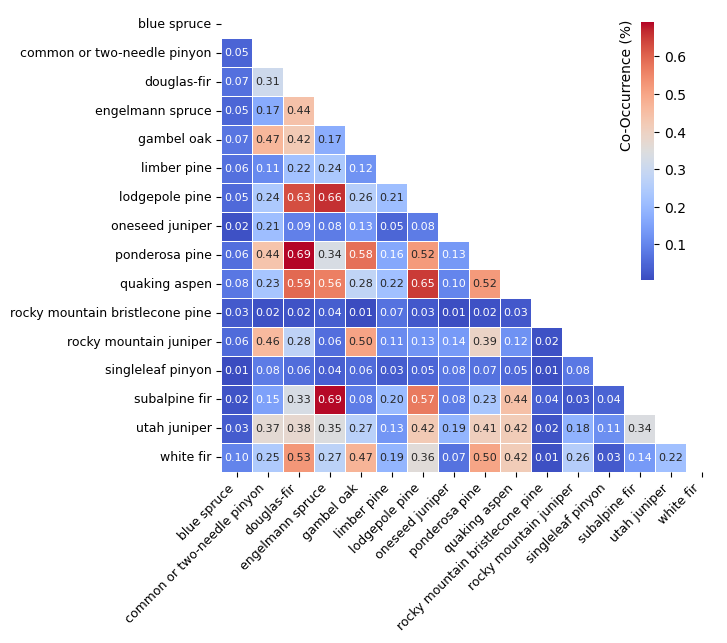

In [22]:
# Mask diagonal values (optional)
mask = np.triu(np.ones_like(coo_pct, dtype=bool))
# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    coo_pct, 
    cmap='coolwarm', 
    annot=True, fmt=".2f", 
    linewidths=0.5, 
    mask=mask, 
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.5}
)
# Improve readability
# Adjust the colorbar placement
cbar = ax.collections[0].colorbar
cbar.ax.set_position([0.65, 0.43, 2, 0.43])  # [left, bottom, width, height]
cbar.ax.xaxis.set_ticks_position("top")  # Move ticks to top
cbar.ax.xaxis.set_label_position("top")  # Move label to top
cbar.set_label("Co-Occurrence (%)", fontsize=10, labelpad=-48, rotation=90, ha="left")
# adjust axis ticks, etc
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel("", fontsize=10)
plt.ylabel("", fontsize=10)

# Save the map
out_png = os.path.join(projdir, 'figures/FigureS3_Species_CoOccurrence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [23]:
# Identify the primary species from the Tree Table
# identify the species which make up 97% of landscape
spp_pr = (
    grid_tm_.groupby('species', as_index=False)
    .agg(
        ba_live=('ba_live', 'sum'),
        tpp_live=('tpp_live', 'sum'),
    )
)
# calculate the fractions for both BALIVE and TPA
spp_pr['ba_live_f'] = spp_pr['ba_live'] / spp_pr['ba_live'].sum()
spp_pr['tpp_live_f'] = spp_pr['tpp_live'] / spp_pr['tpp_live'].sum()
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='ba_live_f', ascending=False)
spp_pr['ba_live_f_csum'] = spp_pr['ba_live_f'].cumsum()
spp_pr['tpp_live_f_csum'] = spp_pr['tpp_live_f'].cumsum()

# which species make up X% of observations?
metric = 'ba_live_f_csum'
thresh = 0.98 # cutoff
top_species = spp_pr[(spp_pr['ba_live_f_csum'] <= thresh) | (spp_pr['tpp_live_f_csum'] <= thresh)]
print(f"\nSpecies making up {round(thresh*100)}% of *{metric}*: \n\n{top_species[['species','ba_live_f','tpp_live_f']]}\n\n")

del spp_pr
gc.collect()


Species making up 98% of *ba_live_f_csum*: 

                        species  ba_live_f  tpp_live_f
8                ponderosa pine   0.275614    0.142250
6                lodgepole pine   0.210088    0.276412
2                   douglas-fir   0.094984    0.059836
9                 quaking aspen   0.093801    0.105509
3              engelmann spruce   0.074626    0.059786
13                subalpine fir   0.062537    0.100735
14                 utah juniper   0.047566    0.018112
15                    white fir   0.046455    0.032667
4                    gambel oak   0.030359    0.152046
1   common or two-needle pinyon   0.026531    0.027361
11       rocky mountain juniper   0.015766    0.012467




650

In [24]:
# calculate the shannon diversity index
def H_index(group, col):
    proportions = group[col].dropna()  # Remove NaNs if any
    return -np.sum(proportions * np.log(proportions))

# calculate the shannon index for grids
shannon = grid_tm_.groupby('grid_idx').apply(lambda g: pd.Series({
    "H_ba": H_index(g, "ba_live_pr"),
    "H_tpp": H_index(g, "tpp_live_pr")
})).reset_index()
# merge back to the dataframe
grid_tm_h = grid_tm_.merge(shannon, on="grid_idx", how="left")

print(shannon.head())
del shannon

  grid_idx      H_ba     H_tpp
0  0819725  1.797801  1.772701
1  0821970  1.447809  1.510831
2  0821974  2.023958  1.944549
3  0821975  1.771131  1.668497
4  0821992  1.709948  1.571350


In [25]:
grid_tm_h.columns

Index(['index', 'grid_idx', 'species', 'tmid_n', 'forest_pct', 'ba_live',
       'ba_dead', 'ba_ld', 'tpp_live', 'tpp_dead', 'tpp_ld', 'tree_ht_live',
       'tree_ht_dead', 'tree_dia_live', 'tree_dia_dead', 'qmd_live',
       'ba_live_total', 'tpp_live_total', 'ba_live_pr', 'tpp_live_pr', 'H_ba',
       'H_tpp'],
      dtype='object')

In [26]:
grid_tm_h.species.unique()

array(['douglas-fir', 'engelmann spruce', 'gambel oak', 'lodgepole pine',
       'oneseed juniper', 'quaking aspen', 'rocky mountain juniper',
       'subalpine fir', 'utah juniper', 'white fir', 'ponderosa pine',
       'common or two-needle pinyon', 'blue spruce', 'limber pine',
       'rocky mountain bristlecone pine', 'singleleaf pinyon'],
      dtype=object)

In [27]:
top_species['species'].unique()

array(['ponderosa pine', 'lodgepole pine', 'douglas-fir', 'quaking aspen',
       'engelmann spruce', 'subalpine fir', 'utah juniper', 'white fir',
       'gambel oak', 'common or two-needle pinyon',
       'rocky mountain juniper'], dtype=object)

In [28]:
# Retain only the top species
grid_tm_h = grid_tm_h[grid_tm_h['species'].isin(top_species['species'].unique())]
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies

spp_grouping = {
    'pinyon|juniper': 'Piñon-juniper',
    'engelmann|subalpine': 'Spruce-fir',
    'ponderosa': 'Ponderosa pine', 
    'lodgepole': 'Lodgepole pine',
    'aspen': 'Quaking aspen',
    'douglas-fir': 'Douglas-fir',
    'white fir': 'White fir',
    'gambel oak': 'Gambel oak',
}
# remap the species to groups
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_tm_h[grid_tm_h['species'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['species'].unique()})
    
# Apply the remap to create a new grouped species column
grid_tm_h['species_gp_n'] = grid_tm_h['species'].map(spp_remap).fillna(grid_tm_h['species'])
# Verify the updated species groups
print(grid_tm_h[['species', 'species_gp_n']].drop_duplicates().head(10))
print(f"\n{grid_tm_h.columns}")

                   species    species_gp_n
0              douglas-fir     Douglas-fir
1         engelmann spruce      Spruce-fir
2               gambel oak      Gambel oak
3           lodgepole pine  Lodgepole pine
5            quaking aspen   Quaking aspen
6   rocky mountain juniper   Piñon-juniper
7            subalpine fir      Spruce-fir
8             utah juniper   Piñon-juniper
9                white fir       White fir
21          ponderosa pine  Ponderosa pine

Index(['index', 'grid_idx', 'species', 'tmid_n', 'forest_pct', 'ba_live',
       'ba_dead', 'ba_ld', 'tpp_live', 'tpp_dead', 'tpp_ld', 'tree_ht_live',
       'tree_ht_dead', 'tree_dia_live', 'tree_dia_dead', 'qmd_live',
       'ba_live_total', 'tpp_live_total', 'ba_live_pr', 'tpp_live_pr', 'H_ba',
       'H_tpp', 'species_gp_n'],
      dtype='object')


In [29]:
# re-aggregate the TreeMap characteristics by FRP grid/species combinations
# summarizes forest metrics by individual species present in the grid cell
# now, summarizes against the new forest groups made above
grid_tm_sp = (
    grid_tm_h.groupby(
        ['grid_idx', 'species_gp_n'], as_index=False
    ).agg(
        tmid_n=('tmid_n', 'max'), # number of unique tm_id contributing
        forest_pct=('forest_pct','max'), # retains the forest pixel count for the grid
        ba_live=('ba_live', 'sum'),
        ba_dead=('ba_dead', 'sum'), 
        ba_ld=('ba_ld', 'sum'),
        tpp_live=('tpp_live', 'sum'),  
        tpp_dead=('tpp_dead', 'sum'),
        tpp_ld=('tpp_ld', 'sum'),
        tree_ht_live=('tree_ht_live', 'mean'),
        tree_ht_dead=('tree_ht_dead', 'mean'),
        tree_dia_live=('tree_dia_live', 'mean'),
        tree_dia_dead=('tree_dia_live', 'mean'),
        H_ba=('H_ba', 'max'),
        H_tpp=('H_tpp', 'max')
    )
)

# Add Quadratic Mean Diameter (QMD) for live trees
# calculated as 'QMD = sqrt( (Basal Area per Acre / Trees per Acre) / 0.005454 )'
# https://www.fs.usda.gov/Internet/FSE_DOCUMENTS/stelprdb5413736.pdf
grid_tm_sp['qmd_live'] = np.where(
    grid_tm_sp['tpp_live'] > 0, 
    np.sqrt(grid_tm_sp['ba_live'] / (grid_tm_sp['tpp_live'] * 0.005454)), 0
)

# calculate gridcell totals and averages
totals = (
    grid_tm_sp.groupby('grid_idx', as_index=False)
    .agg(
        ba_live_total=('ba_live', 'sum'),
        ba_dead_total=('ba_dead', 'sum'),
        tpp_live_total=('tpp_live', 'sum'),
        tpp_dead_total=('tpp_dead', 'sum'),
        qmd_live_mean=('qmd_live', 'mean'), # gridcell average QMD
        tree_ht_live_mean=('tree_ht_live', 'mean'),
        tree_ht_dead_mean=('tree_ht_dead', 'mean'),
        tree_dia_live_mean=('tree_dia_live', 'mean'),
        tree_dia_dead_mean=('tree_dia_dead', 'mean'),
    )
)

# merge back
grid_tm_sp = grid_tm_sp.merge(totals, on='grid_idx', how='left')
# calculate proportions of live basal area and tree/pixel
grid_tm_sp['ba_live_pr'] = grid_tm_sp['ba_live'] / grid_tm_sp['ba_live_total']
grid_tm_sp['tpp_live_pr'] = grid_tm_sp['tpp_live'] / grid_tm_sp['tpp_live_total']

# Check results
print(f"\n{grid_tm_sp.head(10)}\n")

# clean up !
del tree_metrics, grid_tm, grid_tm_h, grid_tm_
gc.collect()


  grid_idx    species_gp_n  tmid_n  forest_pct     ba_live    ba_dead  \
0  0819725     Douglas-fir       8   40.109890   31.070127   6.431147   
1  0819725      Gambel oak       4   40.109890   13.396445   0.000000   
2  0819725  Lodgepole pine       2   40.109890   13.447745   2.344394   
3  0819725   Piñon-juniper       2   40.109890   41.612093   1.407790   
4  0819725   Quaking aspen      18   40.109890  198.828040  80.083648   
5  0819725      Spruce-fir       5   40.109890   56.341770   9.672624   
6  0819725       White fir       6   40.109890   44.784639  16.371779   
7  0821970     Douglas-fir       8   86.813187   35.581438   2.431843   
8  0821970      Gambel oak       5   86.813187   14.973099   0.000000   
9  0821970  Lodgepole pine       5   86.813187   24.533243   3.559111   

        ba_ld    tpp_live    tpp_dead       tpp_ld  ...  ba_dead_total  \
0   37.501274   76.783377    8.252514    85.035892  ...     116.311383   
1   13.396445  390.145696    0.000000   390.145

31

In [30]:
# Re-assess the primary species after the regrouping
# Identify the primary species from the Tree Table
# identify the species which make up 97% of landscape
spp_pr = (
    grid_tm_sp.groupby('species_gp_n', as_index=False)
    .agg(
        ba_live=('ba_live', 'sum'),
        tpp_live=('tpp_live', 'sum'),
    )
)
# calculate the fractions for both BALIVE and TPA
spp_pr['ba_live_f'] = spp_pr['ba_live'] / spp_pr['ba_live'].sum()
spp_pr['tpp_live_f'] = spp_pr['tpp_live'] / spp_pr['tpp_live'].sum()
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='ba_live_f', ascending=False)
spp_pr['ba_live_f_csum'] = spp_pr['ba_live_f'].cumsum()
spp_pr['tpp_live_f_csum'] = spp_pr['tpp_live_f'].cumsum()

# which species make up X% of observations?
metric = 'ba_live_f_csum'
thresh = 0.97 # cutoff
top_species = spp_pr[(spp_pr['ba_live_f_csum'] <= thresh) | (spp_pr['tpp_live_f'] > 0.05)]
print(f"\nSpecies making up {round(thresh*100)}% of total: \n\n{top_species[['species_gp_n','ba_live_f','ba_live_f_csum','tpp_live_f','tpp_live_f_csum']]}\n")

del spp_pr
gc.collect()


Species making up 97% of total: 

     species_gp_n  ba_live_f  ba_live_f_csum  tpp_live_f  tpp_live_f_csum
4  Ponderosa pine   0.281720        0.281720    0.144097         0.144097
2  Lodgepole pine   0.214742        0.496462    0.280001         0.424098
6      Spruce-fir   0.140202        0.636664    0.162605         0.586703
0     Douglas-fir   0.097088        0.733752    0.060613         0.647317
5   Quaking aspen   0.095879        0.829631    0.106879         0.754196
3   Piñon-juniper   0.091853        0.921484    0.058693         0.812889
7       White fir   0.047484        0.968968    0.033091         0.845980
1      Gambel oak   0.031032        1.000000    0.154020         1.000000



0

In [31]:
# subset to the top species a final time
grid_tm_sp = grid_tm_sp[grid_tm_sp['species_gp_n'].isin(top_species['species_gp_n'].unique())]
print(f"Total grids at this stage: {len(grid_tm_sp['grid_idx'].unique())}")
print(f"\nUnique species: \n{grid_tm_sp['species_gp_n'].unique()}")
# number of majority forested grids
n_forest = len(grid_tm_sp[grid_tm_sp['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid_tm_sp)*100,2)}%] predominantly forested grids.\n")

Total grids at this stage: 44439

Unique species: 
['Douglas-fir' 'Gambel oak' 'Lodgepole pine' 'Piñon-juniper'
 'Quaking aspen' 'Spruce-fir' 'White fir' 'Ponderosa pine']

[91.08%] predominantly forested grids.



In [32]:
# check on the aspen composition
# how many grids have at least some aspen component?
spp_idx = grid_tm_sp[grid_tm_sp['species_gp_n'] == 'Quaking aspen']['grid_idx'].unique() # list of grid indices
grid_aspen = grid_tm_sp[grid_tm_sp['grid_idx'].isin(spp_idx)]
# check how many aspen gridcells there are
n_spp_grids = len(grid_aspen['grid_idx'].unique())
print(f"{n_spp_grids} [{round(n_spp_grids/len(grid_tm_sp['grid_idx'].unique())*100,1)}%] grids w/ some aspen.")

26095 [58.7%] grids w/ some aspen.


In [33]:
### Identify dominant species for each grid cell by 'balive' or 'tpa_live'
spps = grid_tm_sp['species_gp_n'].unique()
# print these summaries for all species
# percent of grids in which that species is dominant
metrics = ['tpp_live', 'ba_live', 'qmd_live']  # metrics to assess
dom_dfs = []
for metric in metrics:
    print(f"\nDominance based on *{metric}*\n")
    dom_spp = (
        grid_tm_sp.groupby('grid_idx', as_index=False)
        .apply(lambda df: df.loc[df[metric].idxmax()])
        .reset_index(drop=True))
    # print the dominance for each major forest type
    for spp in spps:
        # Filter for grid cells where species is dominant
        spp_dominant = dom_spp[dom_spp['species_gp_n'] == spp]
        # Count the number of grid cells with aspen dominance
        n_dom = len(spp_dominant['grid_idx'].unique())
        # Print the results
        total_grids = len(grid_tm_sp['grid_idx'].unique())
        spp_pct = round(n_dom / total_grids * 100, 1)
        print(f"\t~ {spp}: {n_dom} grids ({spp_pct}%)")
print("\n")

# save this table as a csv
out_fp = os.path.join(maindir,'data/tabular/mod/model_grid_species_proportions.csv')

del dom_spp, spp_dominant
gc.collect()


Dominance based on *tpp_live*

	~ Douglas-fir: 312 grids (0.7%)
	~ Gambel oak: 9829 grids (22.1%)
	~ Lodgepole pine: 14812 grids (33.3%)
	~ Piñon-juniper: 1806 grids (4.1%)
	~ Quaking aspen: 4286 grids (9.6%)
	~ Spruce-fir: 7173 grids (16.1%)
	~ White fir: 58 grids (0.1%)
	~ Ponderosa pine: 6163 grids (13.9%)

Dominance based on *ba_live*

	~ Douglas-fir: 1176 grids (2.6%)
	~ Gambel oak: 53 grids (0.1%)
	~ Lodgepole pine: 12625 grids (28.4%)
	~ Piñon-juniper: 2502 grids (5.6%)
	~ Quaking aspen: 3602 grids (8.1%)
	~ Spruce-fir: 5907 grids (13.3%)
	~ White fir: 217 grids (0.5%)
	~ Ponderosa pine: 18357 grids (41.3%)

Dominance based on *qmd_live*

	~ Douglas-fir: 7945 grids (17.9%)
	~ Gambel oak: 61 grids (0.1%)
	~ Lodgepole pine: 3132 grids (7.0%)
	~ Piñon-juniper: 8738 grids (19.7%)
	~ Quaking aspen: 1728 grids (3.9%)
	~ Spruce-fir: 985 grids (2.2%)
	~ White fir: 2368 grids (5.3%)
	~ Ponderosa pine: 19482 grids (43.8%)




0

In [34]:
grid_tm_sp.columns

Index(['grid_idx', 'species_gp_n', 'tmid_n', 'forest_pct', 'ba_live',
       'ba_dead', 'ba_ld', 'tpp_live', 'tpp_dead', 'tpp_ld', 'tree_ht_live',
       'tree_ht_dead', 'tree_dia_live', 'tree_dia_dead', 'H_ba', 'H_tpp',
       'qmd_live', 'ba_live_total', 'ba_dead_total', 'tpp_live_total',
       'tpp_dead_total', 'qmd_live_mean', 'tree_ht_live_mean',
       'tree_ht_dead_mean', 'tree_dia_live_mean', 'tree_dia_dead_mean',
       'ba_live_pr', 'tpp_live_pr'],
      dtype='object')

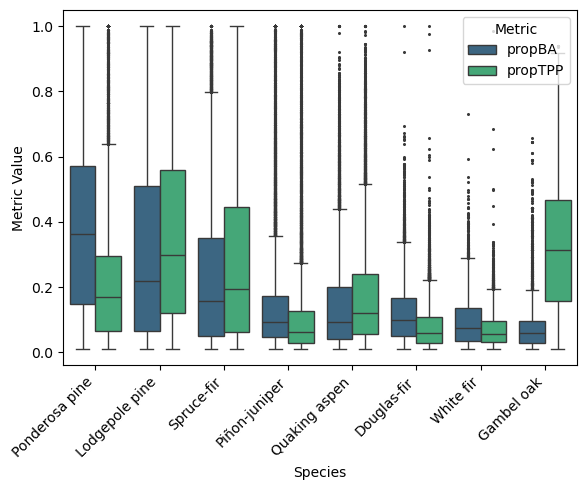

11711

In [36]:
# Plot the distribution of dominance and abundance across forest species groups
# Sort species by mean dominance
sp_order = (
    grid_tm_sp.groupby('species_gp_n')['ba_live_pr']
    .mean().sort_values(ascending=False).index
)
# Reshape the data to long format for easier plotting
df_l = pd.melt(
    grid_tm_sp,
    id_vars=['species_gp_n'],
    value_vars=['ba_live_pr', 'tpp_live_pr'],
    var_name='metric',
    value_name='value'
)

# Set up the plot
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=df_l,
    x='species_gp_n',
    y='value',
    hue='metric',
    order=sp_order,
    palette='viridis',
    flierprops=dict(marker='o', markersize=1.2)
)

# Customize the plot
plt.xlabel('Species')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')

# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['propBA', 'propTPP']  # New labels
plt.legend(
    handles=handles, 
    labels=new_labels,  # Replace default labels
    title='Metric', 
    loc='upper right', 
    bbox_to_anchor=(1, 1)
)

# Finalize and show the plot
plt.tight_layout()

# Save the plot
out_png = os.path.join(projdir, 'figures/FigureS1b_TopSpecies_TreeMetrics_Proportions.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

del df_l
gc.collect()

In [37]:
# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable.csv')
grid_tm_sp.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_treetable.csv


In [38]:
gc.collect()

0

## Plots.

In [ ]:
# merge back to the frp data
grid.drop(columns=['forest_pixels','forest_pct'], inplace=True)
grid_tm_frp = grid.merge(grid_tm_spp_pr, on='grid_index', how='inner')
grid_tm_frp.columns

In [ ]:
del grid_tm_spp, grid_tm_spp_pr
gc.collect()

In [ ]:
grid_tm_frp['species_gp_n'].unique()

In [ ]:
# Save this table out.
# First, extract centroid coords
df = grid_tm_frp.copy()
df = df.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y 
# remove the geomtry field before exporting
df.drop(columns=['geometry'], inplace=True)

# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable_frp.csv')
df.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

del df
gc.collect()

In [ ]:
# plot the distribution of percent cover by forest types
grid_tm_frp['species_gp_n'] = grid_tm_frp['species_gp_n'].astype('category')

spp_order = top_species[top_species['species_gp_n'].isin(grid_tm_frp['species_gp_n'].unique())]
spp_order = spp_order['species_gp_n'].tolist()
grid_tm_frp['species_gp_n'] = pd.Categorical(
    grid_tm_frp['species_gp_n'],
    categories=spp_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=grid_tm_frp,
    col='species_gp_n',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'ba_ld_pr', fill=True, alpha=0.6)

# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Dominance (basal area)", "Density", size=9)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

# Show the plot
plt.show()

In [ ]:
df_long = pd.melt(
    grid_tm_frp,
    id_vars=['species_gp_n'],
    value_vars=['ba_ld_pr', 'tpp_ld_pr', 'qmd_ld_pr'],
    var_name='metric',
    value_name='value'
)

# Set the order of species
spp_order = top_species[top_species['species_gp_n'].isin(spps)]
spp_order = spp_order['species_gp_n'].tolist()
df_long['species_gp_n'] = pd.Categorical(
    df_long['species_gp_n'],
    categories=spp_order,
    ordered=True
)

# Just plot one species
df_long = df_long[df_long['species_gp_n'] == 'Quaking aspen']

# Create the plot with stacked densities
plt.figure(figsize=(6,4))

# Use seaborn's KDE plot for each metric, with species as rows (stacked)
sns.kdeplot(
    data=df_long,
    x='value',
    hue='metric',  # Separate densities by metric
    multiple='stack',  # Stack densities
    fill=True,         # Fill densities for stacking effect
    palette='viridis',
    alpha=0.6
)

# Customize the plot
plt.xlabel("Proportion Value (Dominance/Abundance)", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(title="Metric", labels=["BA", "TPP", "QMD"], fontsize=9)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Species co-occurrence plot
# Threshold species presence where dominance/abundance > 1% of total
dt = 0.01
# Create a binary presence-absence matrix
pres_abs = (
    grid_tm_frp
    .pivot_table(index='grid_index', columns='species_gp_n', values='ba_ld_pr', aggfunc='first')
    .fillna(0)
    .applymap(lambda x: 1 if x >= dt else 0)  # Convert to binary
)

# get the species names and matrix
species = pres_abs.columns
coo_mat = pd.DataFrame(0, index=species, columns=species)
# map across species combinations
for sp1, sp2 in combinations(species, 2):
    # Count co-occurrence (grids where both species are present)
    coo = np.sum(pres_abs[sp1] & pres_abs[sp2])
    coo_mat.loc[sp1, sp2] = coo
    coo_mat.loc[sp2, sp1] = coo  # Symmetry

# Optional: Normalize by the total number of grids for each species
species_totals = pres_abs.sum(axis=0)
norm_mat = coo_mat.div(species_totals, axis=0)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    norm_mat, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Co-Occurrence Frequency'}
)
plt.xlabel("Species")
plt.ylabel("Species")
plt.tight_layout()

out_png = os.path.join(projdir, 'figures/FigureX_Species_CoOccurrence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()